In [1]:
import patsy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from pandas.tools.plotting import scatter_matrix

from sklearn import datasets, linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
%matplotlib inline

In [2]:
## Load the data into a DataFrame
master_df = pd.read_csv('master.csv', encoding='latin-1')
glassdoor_df = pd.read_csv('glassdoor_df.csv', encoding='latin-1')
del master_df['Unnamed: 0']
pd.options.mode.chained_assignment = None

In [3]:
#Removes all NaN Salaries
temp_df = master_df.T
master_df = temp_df[[ind for ind, x in enumerate(master_df['salary']) if x > 0]].T
master_df = master_df.reset_index(drop=True)

In [4]:
#Turns all title strings to lower case and replaces sr. with senior.
master_df['title'] = map(lambda x: x.lower(), master_df['title'])
master_df['summary'] = map(lambda x: x.lower(), master_df['summary'])
master_df['title'] = (master_df['title'].replace( 'sr.','senior ', regex=True))
master_df['title'] = (master_df['title'].replace( 'senior  ','senior ', regex=True))
master_copy = master_df

In [5]:
#Remove title from database
temp_df = master_df.T
temp_df = temp_df[[ind for ind, x in enumerate(master_df['title']) if "title" not in x]].T
master_df = temp_df.reset_index(drop=True)

#Remove Intern from database
temp_df = master_df.T
temp_df = temp_df[[ind for ind, x in enumerate(master_df['title']) if "intern" not in x]].T
master_df = temp_df.reset_index(drop=True)

#Remove Devop from database
temp_df = master_df.T
temp_df = temp_df[[ind for ind, x in enumerate(master_df['title']) if "devop" not in x]].T
master_df = temp_df.reset_index(drop=True)

In [6]:
def bin_titles(title):
    if 'associate' in title:
        return 0
    elif 'junior' in title: 
        return 0
    elif 'entry' in title: 
        return 0
    elif 'senior' in title: 
        return 2
    elif 'principal' in title: 
        return 2
    elif 'lead' in title: 
        return 2
    else: 
        return 1
    
        
master_df['level'] = master_df[['title']].applymap(lambda x: bin_titles(x))

In [8]:
#turns location to State
master_df['state'] = 'ELSE'
for x in range(len(master_df)):
    if 'NY' in master_df['location'][x]:
        master_df['state'][x] = 'NY'
    if 'CA' in master_df['location'][x]:
        master_df['state'][x] = 'CA'
    if 'TN' in master_df['location'][x]:
        master_df['state'][x] = 'TN'
    if 'TX' in master_df['location'][x]:
        master_df['state'][x] = 'TX'
    if 'MA' in master_df['location'][x]:
        master_df['state'][x] = 'MA'
    if 'MD' in master_df['location'][x]:
        master_df['state'][x] = 'MD'
    if 'MI' in master_df['location'][x]:
        master_df['state'][x] = 'MI'
    if 'GA' in master_df['location'][x]:
        master_df['state'][x] = 'GA'
    if 'IL' in master_df['location'][x]:
        master_df['state'][x] = 'IL'
    if 'OH' in master_df['location'][x]:
        master_df['state'][x] = 'OH'
    if 'CO' in master_df['location'][x]:
        master_df['state'][x] = 'CO'
    if 'MN' in master_df['location'][x]:
        master_df['state'][x] = 'MN'
    if 'DC' in master_df['location'][x]:
        master_df['state'][x] = 'DC'
    if 'NJ' in master_df['location'][x]:
        master_df['state'][x] = 'NJ'
    if 'PA' in master_df['location'][x]:
        master_df['state'][x] = 'PA'
    if 'DE' in master_df['location'][x]:
        master_df['state'][x] = 'DE'
    if 'VA' in master_df['location'][x]:
        master_df['state'][x] = 'VA'
    if 'LA' in master_df['location'][x]:
        master_df['state'][x] = 'LA'
    if 'AZ' in master_df['location'][x]:
        master_df['state'][x] = 'AZ'
    if 'SC' in master_df['location'][x]:
        master_df['state'][x] = 'SC'
    if 'WA' in master_df['location'][x]:
        master_df['state'][x] = 'WA'
    if 'AK' in master_df['location'][x]:
        master_df['state'][x] = 'AK'
    if 'KY' in master_df['location'][x]:
        master_df['state'][x] = 'KY'
    if 'IN' in master_df['location'][x]:
        master_df['state'][x] = 'IN'
    if 'FL' in master_df['location'][x]:
        master_df['state'][x] = 'FL'
    if 'UT' in master_df['location'][x]:
        master_df['state'][x] = 'UT'
    if 'RI' in master_df['location'][x]:
        master_df['state'][x] = 'RI'
    if 'WV' in master_df['location'][x]:
        master_df['state'][x] = 'WV'
    if 'NC' in master_df['location'][x]:
        master_df['state'][x] = 'NC'
    if 'Hawaii' in master_df['location'][x]:
        master_df['state'][x] = 'HI'
    if 'Ohio' in master_df['location'][x]:
        master_df['state'][x] = 'OH'
    if 'Remote' in master_df['location'][x]:
        master_df['state'][x] = 'ANY'

In [9]:
#Cleans Reviews Column
master_df['reviews'] = (master_df['reviews'].replace( '[\$,)]','', regex=True ).astype(float))
master_df['reviews'] = master_df['reviews'].fillna(0)

In [10]:
#Cleans Stars Column
master_df['stars'] = master_df['stars'].fillna(0)
master_df['stars'] = master_df[['stars']].astype(float).applymap(lambda x: x//6/2)

In [11]:
def cleanup_salary(salary):
    if "year" in str(salary):
        temp = salary.strip(" a year")
        temp = temp.split('-')
        low_range = int(temp[0].strip().replace("$","").replace(",",""))
        high_range = int(temp[-1].strip().replace("$","").replace(",",""))
        avg = (low_range + high_range) / 2
        salary_list = [low_range,high_range,avg]
    elif "month" in str(salary):
        temp = salary.replace("a month","")
        temp = temp.split('-')
        low_range = int(temp[0].replace("$","").replace(",",""))*12
        high_range = int(temp[-1].replace("$","").replace(",",""))*12
        avg = (low_range + high_range) / 2
        salary_list = [low_range,high_range,avg]
    elif "hour" in str(salary):
        temp = salary.replace("an hour","")
        temp = temp.split('-')
        low_range = float(temp[0].replace("$","").replace(",",""))*2080
        high_range = float(temp[-1].replace("$","").replace(",",""))*2080
        avg = (low_range + high_range) / 2
        salary_list = [low_range,high_range,avg]
    else:
        salary_list = [0,0,0]
        low_range = 0
        high_range = 0
        avg = 0
        
    return low_range, high_range, avg

master_df['salary_clean'] = master_df[['salary']].applymap(lambda x: cleanup_salary(x))

master_df['salary'] = master_df['salary_clean']
master_df.drop('salary_clean', axis=1, inplace=True)

In [83]:
stacked = pd.DataFrame(master_df['title'].str.split().tolist()).stack()
final = pd.DataFrame(stacked.value_counts())
final.reset_index(inplace=True)
final.head()

,index,0
0,analyst,407
1,research,404
2,data,368
3,scientist,289
4,&,113


In [14]:
reg_cp = master_df
reg_cp['data_t'] = 0
reg_cp['scientist_t'] = 0
reg_cp['analyst_t'] = 0
reg_cp['research_t'] = 0
reg_cp['engineer_t'] = 0
reg_cp['quantitative_t'] = 0
reg_cp['learning_t'] = 0
reg_cp['machine_t'] = 0
reg_cp['software_t'] = 0
reg_cp['developer_t'] = 0
reg_cp['statistical_t'] = 0

In [15]:
df_range = len(reg_cp)
for x in range(df_range):
    if 'data' in reg_cp['summary'][x]:
        reg_cp['data_t'][x] = 1
    if 'analyst' in reg_cp['summary'][x]:
        reg_cp['analyst_t'][x] = 1
    if 'learning' in reg_cp['summary'][x]:
        reg_cp['learning_t'][x] = 1
    if 'scientist' in reg_cp['summary'][x]:
        reg_cp['scientist_t'][x] = 1
    if 'engineer' in reg_cp['summary'][x]:
        reg_cp['engineer_t'][x] = 1
    if 'quantitative' in reg_cp['summary'][x]:
        reg_cp['quantitative_t'][x] = 1
    if 'research' in reg_cp['summary'][x]:
        reg_cp['research_t'][x] = 1
    if 'machine' in reg_cp['summary'][x]:
        reg_cp['machine_t'][x] = 1
    if 'software' in reg_cp['summary'][x]:
        reg_cp['software_t'][x] = 1
    if 'developer' in reg_cp['summary'][x]:
        reg_cp['developer_t'][x] = 1
    if 'statistical' in reg_cp['summary'][x]:
        reg_cp['statistical_t'][x] = 1

In [84]:
stacked = pd.DataFrame(master_df['summary'].str.split().tolist()).stack()
final = pd.DataFrame(stacked.value_counts())
final.reset_index(inplace=True)
final.head()

,index,0
0,and,1249
1,data,1143
2,to,699
3,the,624
4,a,558


In [17]:
reg_cp['data'] = 0
reg_cp['machine'] = 0
reg_cp['experience'] = 0
reg_cp['learning'] = 0
reg_cp['scientists'] = 0
reg_cp['scientist'] = 0
reg_cp['health'] = 0
reg_cp['degree'] = 0
reg_cp['research'] = 0
reg_cp['looking'] = 0
reg_cp['analytics'] = 0

In [18]:
df_range = len(reg_cp)
for x in range(df_range):
    if 'data' in reg_cp['summary'][x]:
        reg_cp['data'][x] = 1
    if 'machine' in reg_cp['summary'][x]:
        reg_cp['machine'][x] = 1
    if 'experience' in reg_cp['summary'][x]:
        reg_cp['experience'][x] = 1
    if 'learning' in reg_cp['summary'][x]:
        reg_cp['learning'][x] = 1
    if 'scientists' in reg_cp['summary'][x]:
        reg_cp['scientists'][x] = 1
    if 'scientist' in reg_cp['summary'][x]:
        reg_cp['scientist'][x] = 1
    if 'health' in reg_cp['summary'][x]:
        reg_cp['health'][x] = 1
    if 'degree' in reg_cp['summary'][x]:
        reg_cp['degree'][x] = 1
    if 'research' in reg_cp['summary'][x]:
        reg_cp['research'][x] = 1
    if 'looking' in reg_cp['summary'][x]:
        reg_cp['looking'][x] = 1
    if 'analytics' in reg_cp['summary'][x]:
        reg_cp['analytics'][x] = 1

In [19]:
copy_range = len(reg_cp)
count = 0
for x in range(copy_range):
    count+=reg_cp['salary'][x][2]
mean_sal = count/copy_range

In [21]:
reg_cp['salary_over_mean'] = 0
for x in range(len(master_df)):
    if master_df['salary'][x][2] < mean_sal:
        reg_cp['salary_over_mean'][x] = 0
    else:
        reg_cp['salary_over_mean'][x] = 1

In [150]:
def get_features(dataframe):
    features = patsy.dmatrix('~ C(state)', dataframe)
    X_df = pd.DataFrame(features, columns=features.design_info.column_names)
    X_df.drop('Intercept', axis=1, inplace=True)
    X_df = pd.concat([X_df, dataframe[['level', 'data_t', 'scientist_t', 'analyst_t', 'research_t', 'engineer_t',
                                     'quantitative_t', 'learning_t', 'machine_t', 'software_t', 'developer_t',
                                     'statistical_t', 'data', 'machine', 'experience', 'learning', 'scientists',
                                     'scientist', 'health', 'degree', 'research', 'looking', 'analytics']]], axis=1)
    return X_df
df1 = get_features(reg_cp)

In [151]:
df1.columns

Index([u'C(state)[T.CA]', u'C(state)[T.CO]', u'C(state)[T.DC]',
       u'C(state)[T.DE]', u'C(state)[T.ELSE]', u'C(state)[T.FL]',
       u'C(state)[T.GA]', u'C(state)[T.IL]', u'C(state)[T.IN]',
       u'C(state)[T.MA]', u'C(state)[T.MD]', u'C(state)[T.MI]',
       u'C(state)[T.MN]', u'C(state)[T.NC]', u'C(state)[T.NJ]',
       u'C(state)[T.NY]', u'C(state)[T.OH]', u'C(state)[T.PA]',
       u'C(state)[T.TN]', u'C(state)[T.TX]', u'C(state)[T.UT]',
       u'C(state)[T.VA]', u'C(state)[T.WA]', u'level', u'data_t',
       u'scientist_t', u'analyst_t', u'research_t', u'engineer_t',
       u'quantitative_t', u'learning_t', u'machine_t', u'software_t',
       u'developer_t', u'statistical_t', u'data', u'machine', u'experience',
       u'learning', u'scientists', u'scientist', u'health', u'degree',
       u'research', u'looking', u'analytics'],
      dtype='object')

In [191]:
rst = 69
tsz = 0.69

In [192]:
target = reg_cp['salary_over_mean']

X_train, X_test, Y_train, Y_test = train_test_split(df1, target, test_size=tsz, random_state=rst)

In [193]:
logreg = LogisticRegressionCV(Cs=5, cv=5, solver='liblinear', penalty='l2', scoring='f1_weighted')
cv_model = logreg.fit(X_train, Y_train)

y_pred = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)

            predicted_over  predicted_under
over_mean              465               29
under_mean             124              130
             precision    recall  f1-score   support

          0       0.79      0.94      0.86       494
          1       0.82      0.51      0.63       254

avg / total       0.80      0.80      0.78       748



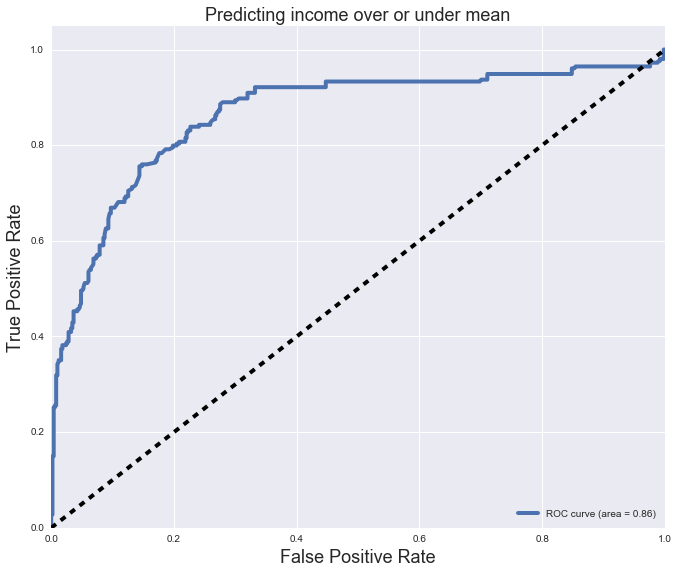

In [194]:
conmat = np.array(confusion_matrix(Y_test, y_pred, labels=logreg.classes_))
confusion = pd.DataFrame(conmat, index=['over_mean', 'under_mean'],
                            columns=['predicted_over', 'predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)
roc_auc_score(Y_test, y_score)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Predicting income over or under mean', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [195]:
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']


gs = GridSearchCV(LogisticRegression(solver='liblinear'),
                 {'C': C_vals,
                 'penalty': penalties},
                 cv=10)
gs.fit(X_train,Y_train);

In [196]:
y_pred2 = gs.predict(X_test)
y_score2 = gs.decision_function(X_test)

            predicted_over  predicted_under
over_mean              152              102
under_mean              34              460
             precision    recall  f1-score   support

          0       0.82      0.93      0.87       494
          1       0.82      0.60      0.69       254

avg / total       0.82      0.82      0.81       748



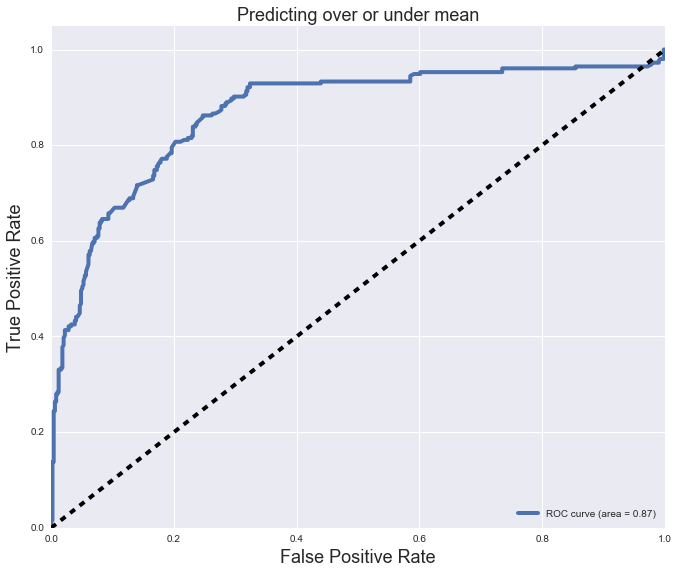

In [197]:
conmat = np.array(confusion_matrix(Y_test, y_pred2, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_mean', 'under_mean'],
                            columns=['predicted_over', 'predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred2)
roc_auc_score(Y_test, y_score2)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score2)
ROC_AUC[1] = auc(FPR[1], TPR[1])

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Predicting over or under mean', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [198]:
'''
test_idx = np.random.uniform(0, 1, len(df1)) <= 0.3
train = df1[test_idx==True]
test = df1[test_idx==False]

#df2 = df1.drop('salary_low', axis=1)

#USE THIS CODE TO RANDOMIZE TO GET RID OF ERROR
#I WAS WRONG MAYDAY MAYDAY SOS-SOS-SOS
'''
print

In [199]:
def get_features(dataframe):
    features = patsy.dmatrix('~ C(state)', dataframe)
    X_df = pd.DataFrame(features, columns=features.design_info.column_names)
    X_df.drop('Intercept', axis=1, inplace=True)
    X_df = pd.concat([X_df, dataframe[['level']]], axis=1)
    return X_df
df2 = get_features(reg_cp)

In [200]:
target = reg_cp['salary_over_mean']

X_train, X_test, Y_train, Y_test = train_test_split(df2, target, test_size=tsz, random_state=rst)

In [204]:
logreg = LogisticRegressionCV(Cs=5, cv=5, solver='liblinear', penalty='l2', scoring='f1_weighted')
cv_model = logreg.fit(X_train, Y_train)

y_pred = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)

            predicted_over  predicted_under
over_mean              415               79
under_mean              83              171
             precision    recall  f1-score   support

          0       0.83      0.84      0.84       494
          1       0.68      0.67      0.68       254

avg / total       0.78      0.78      0.78       748



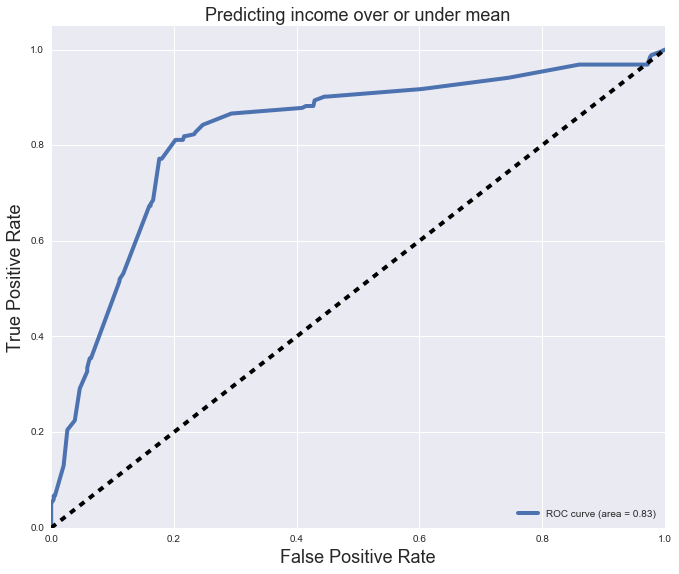

In [202]:
conmat = np.array(confusion_matrix(Y_test, y_pred, labels=logreg.classes_))
confusion = pd.DataFrame(conmat, index=['over_mean', 'under_mean'],
                            columns=['predicted_over', 'predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)
roc_auc_score(Y_test, y_score)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Predicting income over or under mean', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [203]:
df2.columns

Index([u'C(state)[T.CA]', u'C(state)[T.CO]', u'C(state)[T.DC]',
       u'C(state)[T.DE]', u'C(state)[T.ELSE]', u'C(state)[T.FL]',
       u'C(state)[T.GA]', u'C(state)[T.IL]', u'C(state)[T.IN]',
       u'C(state)[T.MA]', u'C(state)[T.MD]', u'C(state)[T.MI]',
       u'C(state)[T.MN]', u'C(state)[T.NC]', u'C(state)[T.NJ]',
       u'C(state)[T.NY]', u'C(state)[T.OH]', u'C(state)[T.PA]',
       u'C(state)[T.TN]', u'C(state)[T.TX]', u'C(state)[T.UT]',
       u'C(state)[T.VA]', u'C(state)[T.WA]', u'level'],
      dtype='object')